In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [16]:
# Загрузка данных
data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep=";", index_col=False)

# Создание целевой переменной для регрессии
# def create_claim_probability(n_claims):
#     """
#     Преобразует количество убытков в вероятность от 0 до 1
#     - 0 убытков: вероятность близка к 0
#     - 1 убыток: вероятность около 0.3-0.5
#     - 2+ убытков: вероятность стремится к 1
#     """
#     if n_claims == 0:
#         return np.random.uniform(0, 0.1)  # Случайный шум для 0 убытков
#     elif n_claims == 1:
#         return np.random.uniform(0.3, 0.5)  # Средняя вероятность для 1 убытка
#     else:
#         # Для 2+ убытков - возрастающая вероятность с насыщением
#         base_prob = 1 - np.exp(-0.5 * n_claims)
#         # Добавляем небольшой случайный шум
#         return min(0.95, base_prob + np.random.uniform(-0.05, 0.05))
# Вариант 1: Логистическая функция
# data['claim_prob'] = 1 / (1 + np.exp(-0.7 * (data['N_claims_year'] - 1)))

# Вариант 2: Нормализация с насыщением
# data['claim_prob'] = np.minimum(data['N_claims_year'] / 3, 1.0)

# Вариант 3: Экспоненциальное преобразование
# data['claim_prob'] = 1 - np.exp(-0.8 * data['N_claims_year'])

def create_claim_probability(n_claims):
    a = -0.7 * (n_claims - 1)
    return 1 / (1 + np.exp(n_claims))#np.minimum(n_claims / 10, 1.0)#1 / (1 + np.exp(a))

# Применяем функцию к данным
data['claim_prob'] = data['N_claims_year'].apply(create_claim_probability)

# Альтернативный вариант - логистическая функция
# data['claim_prob'] = 1 / (1 + np.exp(-0.7 * (data['N_claims_year'] - 1)))

# Предобработка данных
cols_to_drop = ['ID','Date_last_renewal', 'Date_next_renewal', 
                'Date_lapse', 'N_claims_year', 'Cost_claims_year', 'N_claims_history', 
                'R_Claims_history']
data = data.drop(columns=cols_to_drop)

# Преобразуем Date_start_contract в datetime
data['Date_start_contract'] = pd.to_datetime(data['Date_start_contract'], errors='coerce')



C:\Users\andre\AppData\Local\Temp\ipykernel_26820\1388930677.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep=";", index_col=False)


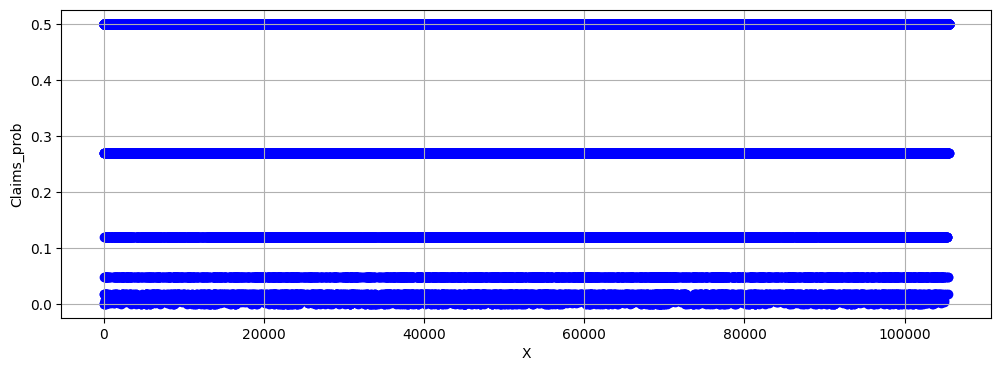

In [17]:
plt.figure(figsize=(12, 4))
x = np.arange(1, len(data['claim_prob']) + 1)
plt.scatter(x, data['claim_prob'], label='Claims Prob', color='blue')
plt.xlabel('X')
plt.ylabel('Claims_prob')
plt.grid(True)
plt.show()

In [11]:
# Обработка датовых колонок
date_columns = ['Date_birth', 'Date_driving_licence']
existing_date_columns = [col for col in date_columns if col in data.columns]

print("Существующие датовые колонки для обработки:", existing_date_columns)

if existing_date_columns:
    for col in existing_date_columns:
        data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')

    # Извлечение числовых признаков из дат
    reference_date = pd.to_datetime('2019-12-31')
    
    if 'Date_birth' in data.columns:
        data['Age'] = (reference_date - data['Date_birth']).dt.days // 365
    
    if 'Date_driving_licence' in data.columns:
        data['Driving_experience'] = (reference_date - data['Date_driving_licence']).dt.days // 365

    # Удаление исходных датовых колонок
    data = data.drop(columns=existing_date_columns, errors='ignore')

# Обработка категориальных переменных
categorical_cols = ['Type_fuel']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Убедиться, что все данные числовые
data = data.apply(pd.to_numeric, errors='coerce')

# Обработка пропущенных значений
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data)
data = pd.DataFrame(data_imputed, columns=data.columns)

# Разделение на признаки и целевую переменную
X = data.drop(columns=['claim_prob'])
y = data['claim_prob']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



Существующие датовые колонки для обработки: ['Date_birth', 'Date_driving_licence']


In [12]:
# Создание нейронной сети для регрессии
class InsuranceNetRegression(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNetRegression, self).__init__()
        self.layer1 = nn.Linear(input_size, 72)
        self.layer2 = nn.Linear(72, 64)
        self.layer3 = nn.Linear(64, 48)
        self.layer4 = nn.Linear(48, 36)
        self.layer5 = nn.Linear(36, 24)
        self.output = nn.Linear(24, 1)
        self.relu = nn.ReLU()
        # Сигмоида для ограничения выхода в диапазоне [0, 1]
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.sigmoid(self.output(x))  # Сигмоида для вероятности
        return x

Размерность входа: 22
Epoch [10/250], Loss: 0.2159
Epoch [20/250], Loss: 0.1786
Epoch [30/250], Loss: 0.0727
Epoch [40/250], Loss: 0.0125
Epoch [50/250], Loss: 0.0127
Epoch [60/250], Loss: 0.0129
Epoch [70/250], Loss: 0.0129
Epoch [80/250], Loss: 0.0129
Epoch [90/250], Loss: 0.0129
Epoch [100/250], Loss: 0.0129
Epoch [110/250], Loss: 0.0129
Epoch [120/250], Loss: 0.0129
Epoch [130/250], Loss: 0.0128
Epoch [140/250], Loss: 0.0128
Epoch [150/250], Loss: 0.0128
Epoch [160/250], Loss: 0.0127
Epoch [170/250], Loss: 0.0126
Epoch [180/250], Loss: 0.0124
Epoch [190/250], Loss: 0.0122
Epoch [200/250], Loss: 0.0120
Epoch [210/250], Loss: 0.0118
Epoch [220/250], Loss: 0.0117
Epoch [230/250], Loss: 0.0116
Epoch [240/250], Loss: 0.0115
Epoch [250/250], Loss: 0.0114


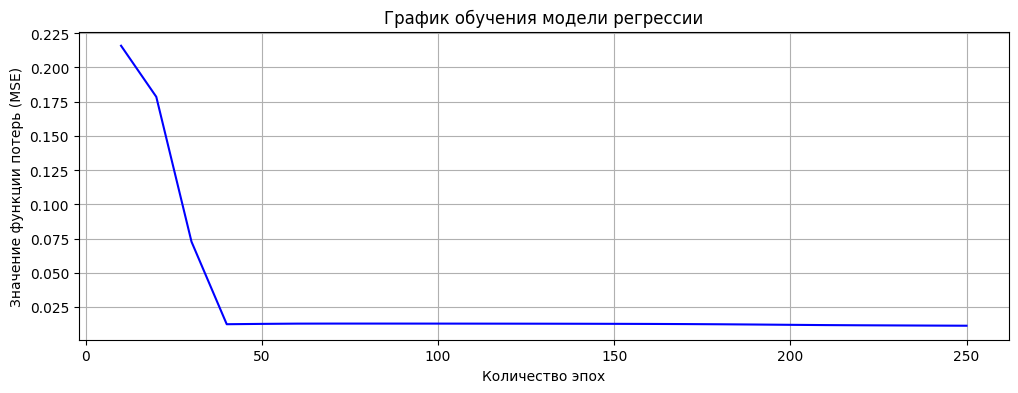

In [14]:
# Инициализация модели
input_size = X_train_tensor.shape[1]
print(f"Размерность входа: {input_size}")
model = InsuranceNetRegression(input_size)

# Функция потерь и оптимизатор для регрессии
criterion = nn.MSELoss()  # Среднеквадратичная ошибка
# Альтернатива: criterion = nn.L1Loss()  # Средняя абсолютная ошибка
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
epochs = 250
losses = []
epochs_plt = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())
        epochs_plt.append(epoch+1)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.plot(epochs_plt, losses, label='Функция потерь (MSE)', color='blue')
plt.title('График обучения модели регрессии')
plt.xlabel('Количество эпох')
plt.ylabel('Значение функции потерь (MSE)')
plt.grid(True)
plt.show()



MAE (Средняя абсолютная ошибка): 0.0570
MSE (Среднеквадратичная ошибка): 0.0116
RMSE (Среднеквадратичное отклонение): 0.1076
R² (Коэффициент детерминации): 0.0187
MAPE (Средняя абсолютная процентная ошибка): 73.0231%


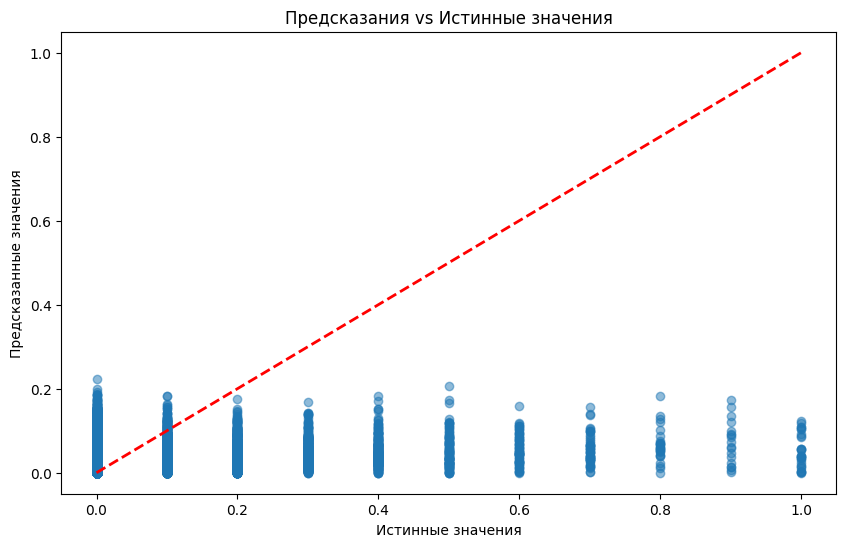

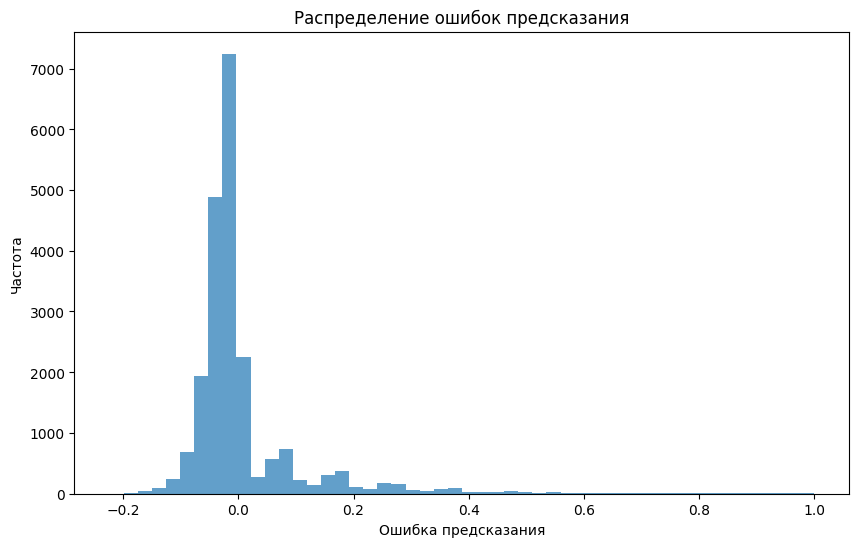

In [15]:
# Оценка модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Метрики регрессии
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE (Средняя абсолютная ошибка): {mae:.4f}')
print(f'MSE (Среднеквадратичная ошибка): {mse:.4f}')
print(f'RMSE (Среднеквадратичное отклонение): {rmse:.4f}')
print(f'R² (Коэффициент детерминации): {r2:.4f}')

# Дополнительные метрики
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.inf
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE (Средняя абсолютная процентная ошибка): {mape:.4f}%')

# Визуализация предсказаний vs истинные значения
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Истинные значения')
plt.show()

# Распределение ошибок
errors = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания')
plt.show()